# Big Data and Finding the "needle in the haystack" galaxies
*A python excersie notebook written by Lewis McMillan, Summer 2020. This notebook has benifited from examples provided by Rita Tojeiro, and the help of Anne-Marie Weijmans, and Simon Reynolds.*

In this notebook you will use data from the Sloan Digital Sky Survey (SDSS), to explore how astronomers interact with "big data", and how astronomers can use various different measurments of galaxies shapes in order to find spiral galaxies, the mergering of multiple galaxies, and other interesting galaxies.

## SDSS and SciServer

As mentioned above, in this notebook we will use data from SDSS, which is is the largest astronmical dataset in the world currently. For eachs nights observing it generates around 200Gb of data. The laptop this notebook was written on has 256Gb of storage space, meaning that I could fit 1 nights observing data on my laptop with some space left over for all the programs I need to analyse the data.

If you are reading this then we assume that you havel alredy followed the instructions to get an account on SciServer, and have uploaded this notebook. In addition to this we assume that you are familiar with basic python, dataframe manipulation, and matplotlib commands. If not please complete Rita Tojeiro's notebook's which cover these topics: link here

Some of the code in this notebook may appear advanced and confusing. However, these bits will be labelled as such so you don't need to worry how they achieve a task, just understand what the overall code snippet is doing.

### Install required Python libraries
The following prompt only needs to be run once

In [ ]:
#install python libraries that are needed
!pip install dataclasses                           # needed as Python is a lower version than code needs
!pip install astropy                               # general purpose astronomy library
!pip install photutils                             # photomertry general purpose library
!pip install scikit-image                          # image anaylsis general purpose library
!pip install tqdm                                  # pretty progress bar

### Import libraries
To get started we first install and then import all the libraries we will need in this notebook

In [1]:
# move to correct folder
from pawlikMorphLSST import Image, helpers, pixmap, imageutils, skyBackground, asymmetry # Library for analysing galaxies
print("Galaxy analysis code imported")

# Import Python libraries to work with SciServer
import SciServer.CasJobs as CasJobs                 # query with CasJobs
import SciServer.SkyServer as SkyServer             # for getting jpg of galaxies
print('SciServer libraries imported')

# Import other libraries for use in this notebook.
import numpy as np                                  # standard Python lib for math ops
import pandas as pd                                 # data manipulation package
import matplotlib.pyplot as plt                     # another graphing package
from pathlib import Path                            # manage local files in your Compute containers
from astropy.visualization import ZScaleInterval    # for plotting clear images
from tqdm import tqdm_notebook                      # for a nice progress bar
from concurrent.futures import ProcessPoolExecutor  # for running the code on more than 1 cpu
from IPython.display import clear_output            # allow nice printing
import time                                         # allows the timing of code
print('Supporting libraries imported')

# Apply some special settings to the imported libraries
# ensure columns get written completely in notebook
pd.set_option('display.max_colwidth', -1)

# for plotting clear images
zscale = ZScaleInterval()

# do *not* show python warnings 
import warnings
warnings.filterwarnings('ignore')
print('Settings applied')

Galaxy analysis code imported
SciServer libraries imported
Supporting libraries imported
Settings applied


## Querying the SDSS database

The SDSS data is stored in a SQL database. Databases can be thought of as large tables of information. SQL is  one language that can be used to communicate with databases via "queries". For each query command, the database returns an answer. Usually, this is a subsample of the original database, though SQL can operate on the data very effectively too. In this tutorial we will submit queries to the SDSS database to gather the information that we need, and we will use Python to operate on, manipulate, and vizualise that data.

An extensive tutorial on how to query the SDSS database is provided here: http://skyserver.sdss.org/dr16/en/help/howto/search/searchhowtohome.aspx . In short, nearly every SQL command consists of three blocks:

The SELECT block: it defines the quantities that you want your query to return.
The FROM block: it defines which tables of the database you want SQL to look in.
The WHERE block: it defines any constraints on the data that you want to impose.
In this Lab you won't have to write SQL queries from scratch, only execute commands that are already written for you.

Using SQL and SciServer to return galaxy data
For the database schema and documentation see http://skyserver.sdss.org/dr16/en/help/browser/browser.aspx The following query returns specific information on a sample of galaxies, as a Pandas dataframe.


In [2]:
# Find objects in the Sloan Digital Sky Survey's.
#
# Query the Sloan Digital Sky Serveys' NSA catalog of galactical objects.
# For the database schema and documentation see http://skyserver.sdss.org/dr16/en/help/browser/browser.aspx?cmd=description+nsatlas+U#&&history=description+nsatlas+U
#
# This query finds all galaxies in the value added catalogue PawlikMorph and matches this information to the
# MaNGA catalogue in order to get galaxies positions.
# Finally we discard any galaxies that have incomplete measurments
#
# First, store the query in an object called "query"
query="""
select distinct m.objra, m.objdec, p.A, p.[As], p.As90, p.S, p.G, p.C2080, p.C5090, p.M20, p.run, p.rerun, p.camcol, p.field
from dbo.PawlikMorph p
  join dbo.mangaDAPall m
  on m.mangaID = p.mangaid
  """

#Then, query the database. The answer is a table that is being returned to a dataframe that we've named all_gals.
all_gals = CasJobs.executeQuery(query, "dr16")

print("SQL query finished.")
print(f"SQL query returned {len(all_gals.index)} galaxies")

SQL query finished.
SQL query returned 4603 galaxies


The dataframe that is returned, named all_gals, holds the following quantities for each galaxy:
 * objra, objdec = The position of the galaxy. RA is the Right Ascension coordinate in degress, and DEC is the Declination corordiante in degrees
 * A = the asymmetry
 * As = the shape asymmetry at 180 degrees
 * As90 = the shape asymetry at 90 degrees
 * S = Smoothness parameter
 * G = Gini index
 * C2080, C5090 = The concentraion of light within a certain annulus
 * M20 = The 2nd moment of light
 * run, rerun, camccol, field = information about which part of the camera took the image
 
Lets look at what all this data looks like, but first lets add a new column to the dataframe which contains the path to the image on SciServer. This will be useful later in the notebook.
To do this we need the information about which part of the camera took the image.

In [3]:
# this function is advanced, and you do not need to understand it
# The function in simple terms add a column to the data we just downloaded.
# This column is the location of the image in the files ystem
def makename(df):
    root = "/home/idies/workspace/sdss_das/das2/imaging/"
    df["fname"] = df.apply(lambda row: root + f"{int(row.run)}/{int(row.rerun)}/corr/{int(row.camcol)}/fpC-{int(row.run):06}-r{int(row.camcol)}-{int(row.field):04}.fit.gz", axis=1)
    return df

In [4]:
# add filename column
all_gals = makename(all_gals)
# View the information of the first 10 galaxies retrieved
all_gals[0:10]

,objra,objdec,A,As,As90,S,G,C2080,C5090,M20,run,rerun,camcol,field,fname
0,27.475456,13.126633,-0.022468,0.149598,0.155957,0.049302,0.551373,3.09359,1.88380,-2.031580,1035,40,2,144,/home/idies/workspace/sdss_das/das2/imaging/1035/40/corr/2/fpC-001035-r2-0144.fit.gz
1,27.529863,13.110374,0.043261,0.138830,0.173077,0.096871,0.653915,3.32362,2.13837,-2.078290,1035,40,2,144,/home/idies/workspace/sdss_das/das2/imaging/1035/40/corr/2/fpC-001035-r2-0144.fit.gz
2,27.565306,13.140773,0.060645,0.171206,0.194553,0.115196,0.592129,2.94275,1.94163,-1.819910,1035,40,2,144,/home/idies/workspace/sdss_das/das2/imaging/1035/40/corr/2/fpC-001035-r2-0144.fit.gz
3,27.653662,13.110200,0.165430,-99.000000,-99.000000,0.155478,0.826167,7.45512,5.86891,-0.568051,1035,40,2,145,/home/idies/workspace/sdss_das/das2/imaging/1035/40/corr/2/fpC-001035-r2-0145.fit.gz
4,27.842783,13.060335,0.204199,-99.000000,-99.000000,0.172169,0.849354,7.14371,5.69862,-0.552881,1035,40,2,146,/home/idies/workspace/sdss_das/das2/imaging/1035/40/corr/2/fpC-001035-r2-0146.fit.gz
5,27.886442,12.699600,0.010838,0.150585,0.690546,0.281075,0.456304,3.34295,2.06500,-1.765870,1035,40,1,147,/home/idies/workspace/sdss_das/das2/imaging/1035/40/corr/1/fpC-001035-r1-0147.fit.gz
6,28.079226,13.634056,0.051562,0.170410,0.355398,0.070220,0.542558,3.69002,2.13114,-0.907639,1035,40,3,147,/home/idies/workspace/sdss_das/das2/imaging/1035/40/corr/3/fpC-001035-r3-0147.fit.gz
7,28.185047,13.192551,0.030504,0.098608,0.207012,0.089205,0.650681,3.05745,1.91781,-2.076980,1035,40,2,148,/home/idies/workspace/sdss_das/das2/imaging/1035/40/corr/2/fpC-001035-r2-0148.fit.gz
8,28.375704,14.570949,0.043704,0.165480,0.434473,-99.000000,0.491647,3.35654,1.75424,-2.085590,1043,40,5,185,/home/idies/workspace/sdss_das/das2/imaging/1043/40/corr/5/fpC-001043-r5-0185.fit.gz
9,28.443092,12.880449,0.079273,0.182746,0.226987,0.131965,0.628332,4.12512,2.52833,-1.914470,1043,40,1,186,/home/idies/workspace/sdss_das/das2/imaging/1043/40/corr/1/fpC-001043-r1-0186.fit.gz


# Manual analysis
In order to get a feel for how an astronomer can manually classify galaxies into different types, and how long it takes to classify each one the code below will plot 16 colour images of random galaxies from the dataset for you to try and classify.

## Exercise:
1. Classify each image into its morphological type, i.e spiral, elliptical, ring or other. You may want to   refer to LINK to help with classification.

Read image 16 of 16
Plotting images...


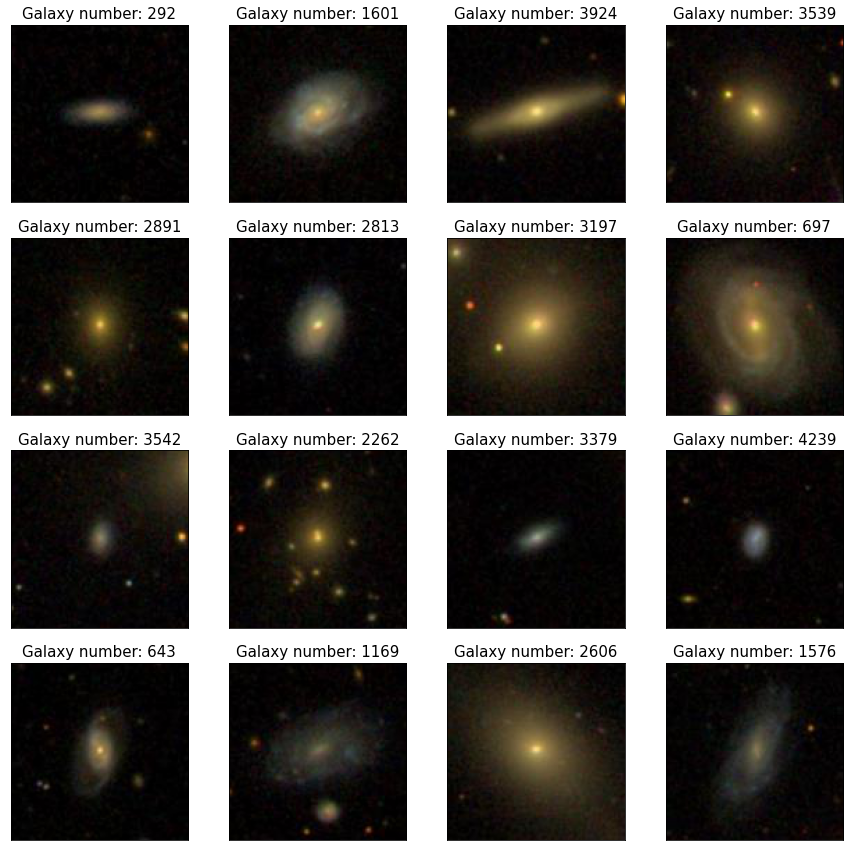

In [5]:
# The following bit of code plots the 16 random galaxies from the data we downloaded.
# Everytime it is run it will return different galaxies.

# display some galaxies in a 4x4 grid
fig, axs = plt.subplots(4, 4, figsize=(15, 15))
# generate a list of 16 random numbers
numbers = np.random.randint(len(all_gals.index), size=16)

# ravel turns a multidimensional array into a 1D array
# this make it easy to manipulate in a loop
axs = axs.ravel()

i = 0
#set height and size of images
width, height = 128, 128
scale = 60. / width #  set image scale to that of 1 arcmin
# loop over the random numbers in the list
for i, idx in enumerate(numbers):
    # print progress
    clear_output(wait=True)
    print(f"Read image {i+1} of 16")
    # get galaxy position
    ra, dec = all_gals["objra"].iloc[idx], all_gals["objdec"].iloc[idx]
    # download colour image of galaxy
    img = SkyServer.getJpegImgCutout(ra=ra, dec=dec, width=width, height=height, scale=scale,dataRelease='DR16')

    # plot image and remove axis ticks
    axs[i].imshow(img, origin="lower")
    axs[i].set_title(f"Galaxy number: {idx}", fontsize=15)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
print("Plotting images...")

# Analysis of a single galaxy
Now lets take your favoutite galaxy number from the plots above and use it in the following section, where we will get the computer to analyse it.

In [6]:
fav_galaxy = all_gals.iloc[1749] # select favourite galaxy
# get the filesystem location and position in the sky of this galaxy
filename = fav_galaxy["fname"]
ra, dec = fav_galaxy["objra"], fav_galaxy["objdec"]
# read in image and crop to area of interest. "sdss" tells the code to read in the image in the SDSS format
image = Image.readImage(filename, ra, dec)

Before we analyse any real data let us first look a single image so that we can understand the data we are dealing with. Currently the image is stored in the variable "image".

## Exercise
1. Plot the image stored in the variable "image". You might want to look at Matplotlib's [imshow](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.imshow.html) function
2. Comment on how this image differs from the colour version above.

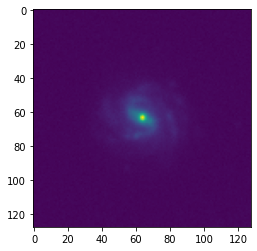

In [7]:
#1. possible solution
plt.imshow(image)
# 2. Student should comment that image is "harder" to see. i.e the galaxies features appear to be fainter.
# The image is also no longer in "colour"
# If student didnt use origin="lower" then comments on how the galaxy is rotated are also acceptable.

The image you just plotted is a FITS image. A [FITS](https://en.wikipedia.org/wiki/FITS) image is not just an image storage file type. It can also store various metadata about the image. Astronomers frequently use this ability to store information about how the telescope captured the data, and where on the nights sky the image was taken. In this notebook we won't worry about this metadata, and just focus on the images.

## Preprocessing the image
First we preprocess the image so that it is suitable for analysis.
This is done by first removing any source of light in the image that is not the "main" source. This means that we will remove all stars in the image that are not close to the galaxy.

These functions are advanced, and you do not need to understand how they work.
Each function below describes what it does and that is enough for this notebook.

In [8]:
# remove external light sources
image = imageutils.maskstarsSEG(image)

Next we estimate the value of the sky. This means we count all the values of the pixels that are not part of the galaxy. We then tak an average of these values to get out estimate for the value of the sky. The image below shows the sky pixels as noise around the galaxy (bright yellow blob).

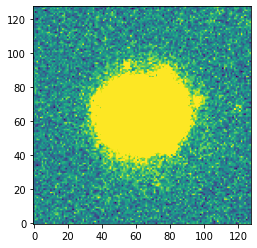

In [9]:
# estimate skybackground
skybgr, skybgr_err, *_ = skyBackground.skybgr(image)
vmin, vmax =  zscale.get_limits(image)
plt.imshow(image, vmin=vmin, vmax=vmin+30, origin="lower")

The penulitmate step is to calculate the galaxy mask. A galaxy mask is an image where all the pixels have the values 1 or 0. Where the mask is 1, then that part of the image belongs to the galaxy, where it is 0 then that pixel belongs to the sky.
Defining a galaxy mask allows us to easily compute more complex parameters related to the galaxy when anaysing the images of the galaxy.

In [10]:
# create image where the only bright pixels are the pixels that belong to the galaxy
mask = pixmap.pixelmap(image, skybgr + skybgr_err, 3)

### Excercise:
1. Plot both the image of your favourite galaxy from above alongside its mask
2. Comment on the overall shape of the mask. How does your what your eye can see compare to what the computer algorithm "see"?. You might want to play with the vmin and vmax values of the plot.

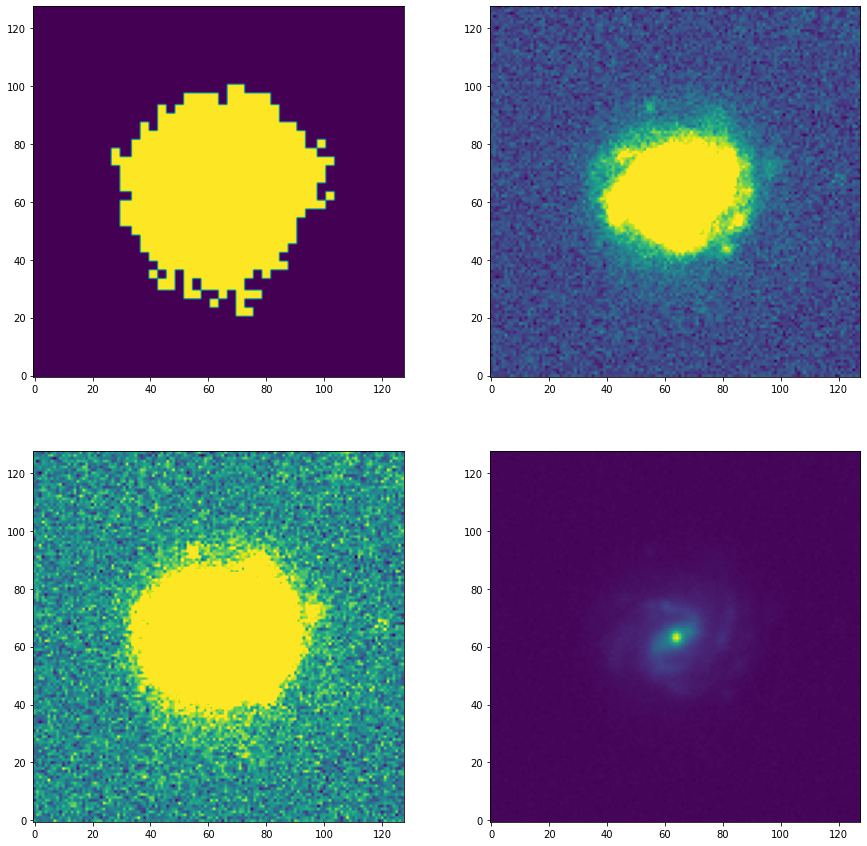

In [11]:
# possible solution
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs = axs.ravel()
axs[0].imshow(mask, origin="lower")
vmin, vmax = zscale.get_limits(image)
axs[1].imshow(image, vmin=vmin, vmax=vmax, origin="lower")
axs[2].imshow(image, vmin=vmin, vmax=vmin+30, origin="lower")
axs[3].imshow(image, origin="lower")

# Image analysis
In order to illustrate how the image analysis method works for galaxies, we will apply the technique to Emoji's.
First we need to load some libraries to process the emojis so that they are in a suitable format for the code 

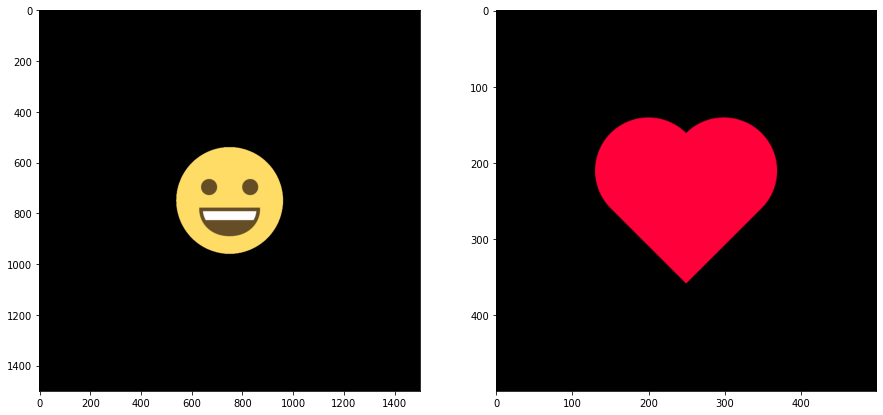

In [12]:
# import modules from image processing library
from skimage import io, color, transform
# read in the two images and plot them
smiley = io.imread("emoji-1.png")
heart = io.imread("emoji-2.png")
# plot emojis
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].imshow(smiley)
axs[1].imshow(heart)

We define a function that carries out all the processing steps for us

In [13]:
# Advanced code. Don not need to understand how this function works
# set a seed so that the results are repoducible
np.random.seed(1)
# Porcess emojis so that galaxy analysis code can analyse them
def preprocessEmoji(img):
    # convert image to grayscale
    emoji = color.rgb2gray(img)
    # shrink image so that code can process image in a timely manner
    emoji = transform.resize(emoji, (500, 500))
    # add some noise to image so that code can process the images as expected
    emoji += (1./50.) * np.random.standard_normal(size=(500, 500))
    return emoji

Lets see how these preprocessing steps has affected the images

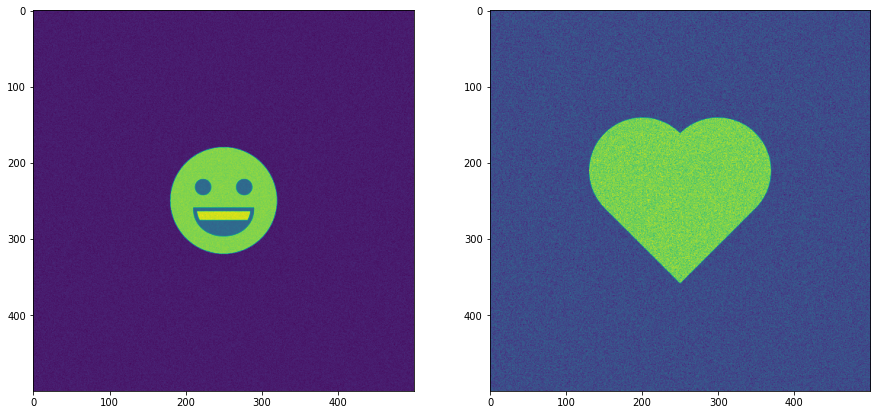

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
smiley = preprocessEmoji(smiley)
heart = preprocessEmoji(heart)
axs[0].imshow(smiley)
axs[1].imshow(heart)

As before lets calculate the "sky" value and generate the image masks

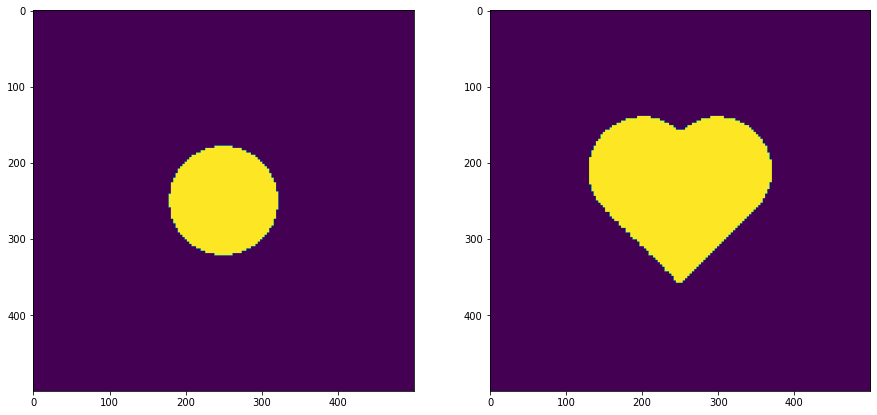

In [15]:
# get "sky" estimates and generate masks
# skybgr returns multiple variables, we are only interested in the first two
# we therfore use the advanced unpacking (*) to stick all the unwanted variables in rest
skybgr, skybgr_err, *rest = skyBackground.skybgr(smiley)
smileyMask = pixmap.pixelmap(smiley, skybgr + skybgr_err, 3)

skybgr, skybgr_err, *rest = skyBackground.skybgr(heart)
heartMask = pixmap.pixelmap(heart, skybgr + skybgr_err, 3)

# plot masks
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].imshow(smileyMask)
axs[1].imshow(heartMask)

Finally lets run the analysis code on the Emoji's. While the next step runs please continue to the next part of the text as this can take around a minute to print a result.

In [16]:
# Calculate asymmetries
A, As, *rest = asymmetry.calculateAsymmetries(smiley, smileyMask)
print(f"Smiley: A: {A:0.3f}, As: {As:.3f}")
A, As, *rest = asymmetry.calculateAsymmetries(heart, heartMask)
print(f"Heart: A: {A:0.3f}, As: {As:.3f}")

Smiley: A: 0.096, As: 0.017
Heart: A: 0.128, As: 0.166


## Symmetry

calculateAsymmetries, as the name implies, calculates several asymmetry parameters of the input image using the image and its mask. 

So why is calculating a galaxies (or Emoji's) asymmetry important? The asymmetry parameters give vital information about the shape of the galaxy, allowing astronomers to search for interesting galaxies. 

Of particular interest are galaxies where they have undergone a merger with another galaxy, or have been disturbed by another galaxy. Investigating these "messed up" galaxies allow astronomers to get insights into the life cycle of galaxies. 

These messed up galaxies are fairly easy to identify by eye, however to to the sheer number of galaxies detected in the SDSS database it is not possible for a person to go through all the galaxies by hand and pick out the interesting galaxies. We therefore rely on computer algorithms to do this for us.

So how does a computer define asymmetry? We will explore this by first examining how a human does this.

## Exercise:
1. How many lines of symmetry do the two Emoji images have?
2. If the smiley was just a circle (i.e had no face) would it have any more symmetries?
3. How symmetric is your favourite galaxy from before. Does it have any lines of symmerty?
4. What process did you use to determine the lines of symmetry in the Emoji example?

Possible solutions:
1. The smiley has 1, as does the heart
2. It now has rotational symmetry and infinte many lines of symmetry
3. Depends on the galaxy choosen.
4. Student should explain the process of finding lines of symmetry, i.e folding over the images along different creases

Now that you have a feel for how a human might classify symmetry we can move on to programming the computer to find symmetries as well.
Finding lines of symmetry computationally is not straight forward for complex shapes. 
We could do as you most likely did in your head, draw lines then mirror the image to see it is symmertic. However, to properly do this we would have to draw hundreds to thousands of lines and check each timne to see if any them give a line of symmetry.

We therefore, use a quick way of checking the symmetry. We check if there is rotational symmetry.
To achieve this we rotate the image by 180 degrees, and then take it away from the original image. To get a final number we then count up the number of pixels in the difference image.
Below is a function that helps to do this. Note for the purposes of this notebook we do not calculate a final number as this is a bit more involved than can be done in an afternoon.

In [17]:
# Advanced code, do not need to understand
# code rotates image and subtracts it from original image
def rotationalDifference(img, angle):
    # set centre point
    point = (250, 250)
    # rotate iage angle degress around point
    rotate = transform.rotate(img, angle, center=point, preserve_range=True)
    # takeaway rotated image from original image
    res = np.abs(img - rotate)
    return res

## Exercise
1. Calculate the asymmetry image using the above function and plot the result for the heart and simley face
2. Do the same but this time for the image masks
3. Note any difference in calculating the asymmetry for the images and the masks.

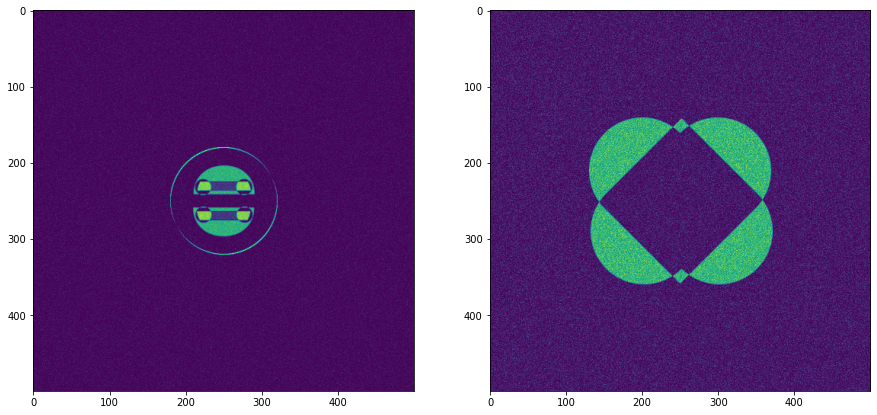

In [18]:
# possible solution
smileyDiff = rotationalDifference(smiley, 180.)
heartDiff = rotationalDifference(heart, 180.)

fig, axs = plt.subplots(1, 2, figsize=(15,8))
axs[0].imshow(smileyDiff)
axs[1].imshow(heartDiff)

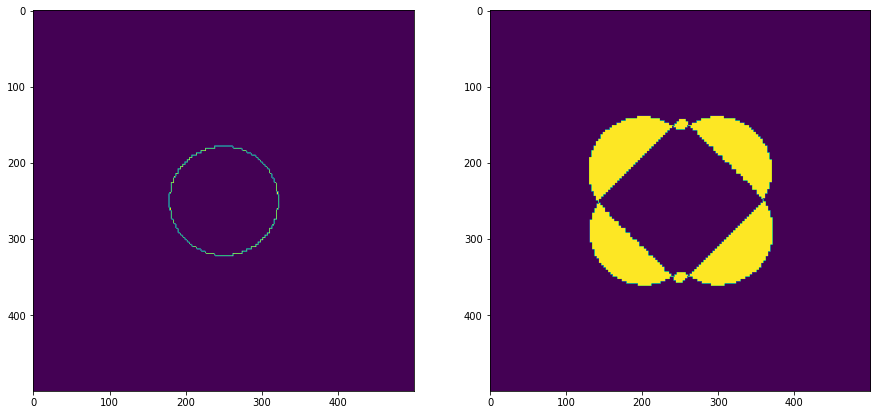

In [19]:
smileyDiff = rotationalDifference(smileyMask, 180.)
heartDiff = rotationalDifference(heartMask, 180.)

fig, axs = plt.subplots(1, 2, figsize=(15,8))
axs[0].imshow(smileyDiff)
axs[1].imshow(heartDiff)

possible solution
3. mask asymmetry is less affected by noise. Mask asymmetry is also not affected by "internal"
features of the orginal image, such as the face on the simely face.

The two different ways of calculating asymmetry used above are called the Asymmetry (A) and the shape asymmetry (As). Asytmmetry (A), is the example above where we use the image as it is. In the case with the simley face, this led to a larger asymmetry value compared to that of its shape asymmetry due to the emoji's face contirbuting more to the overall asymmetry. In the case where the smiley's mask were used (shape asymmetry) this led to a smaller asymmerty as the internal features of the emoji do not contirbute to the asymmetry at all.
Shape asymmetry is better at finding "messed up" galaxies as it places higher values on the overal shape of the galaxy, rather than its internal structure.

# Big data

Now that you have an understanding of the tasks faced by astronomers in finding the right type galaxies to study, we will introduce some of the tools that help astronomers and other scientisits tackle "big data".

The first such tool you have been using the wholetime you have been working on this notebook!
As mentioned in the introduction, SDSS can generate upto 200Gb of data a night, meaning it is infeasible to store all the data it generates on your personal computer or laptop. 
Therefore, a new paradigm has been introduced where instead of taking the data to the code for analysis, we take the code to the data. 
This means that the data is stored on some large secure server somewhere, and you upload the code to the server and set it running. This allows the code to access the data without the need to download the data.
So in using SciServer and this notebook you have unknowingly been using this paradigm without realising it!

The next tool in the astronomers toolbox is the full utilisation of a computers Central processing unit (CPU). Nowadays, most CPU's are actually composed of two or more smaller CPU's, called cores. One reason modern CPU's are made up of multiple cores, is that it is cheaper and more energy efficent to bundle multiple cores into one CPU, than it is to make one really fast core.

Running code on more than one core is called parallelisation of the code. Parallelisation of code is not always an easy task, and can require a complete rewrite of the code in order to make it work. Fortunatly for us the code we are using is classed "embarrassingly parallel". This means that is really esay to make parallel, as all we need to do is tell each core to analyse a different subset of images each. So if we use two cores we would expect the code to runs two times faster, if we used 8 cores it should run 8 times faster and so on.

To investigate the idea of using the whole CPU vs parts of the whole CPU, we will time how long the code takes to execute, and investigate Amdahl's law: https://en.wikipedia.org/wiki/Amdahl%27s_law

To time code we will use the time module, and the helper function helpers.analyseImage.
The time module functions like a stopwatch. You have to start the timer just before the code start, thens stop the timer when the code finishes.
An example of this is shown below

In [20]:
start = time.time()         # start timer
for i in range(1000000):    # run code. In this case we calculate the square of the current loop iteration
    squared = i**2
finish = time.time()        # stop timer
totaltime = finish - start  # calculate time code ran for
print(totaltime)

0.6942493915557861


We can define the speed up of a program executed in parallel as $S=\frac{t_1}{t_n}$, where S is the speedup, $t_n$ is the time take to run the code on $n$ cores, and $t_1$ is the time taken to run the code on 1 core.
So if a piece of code takes 10s to run on 1 core, and 5s to run on 2 cores, then the speed up is: $S=\frac{10}{5}=2$.

## Exercise

1. Using the following snippets of code, time how long it takes to analyse 50 images of galaxies on 1, 2, 3, 4, 6, 8, 10, 12, 14, 16, 18, and 20 cores. Add these times to the empty timings list below or store them via another method.
2. Plot a graph of number of cores vs time for the above datapoints. Make sure your plot has appropriate labels and titles.
3. Calculate the speed up for each data point. Then plot core number vs speed up.
4. On this same plot, plot a straight line of y=mx. You may want to use np.linspace or np.arange to generate the data for this.

In [21]:
# This snippet create a list of filenames, and positions that analyseImage requires to run
info = []
for i in range(0, 50):
    ra, dec = all_gals["objra"].iloc[i], all_gals["objdec"].iloc[i]
    name = all_gals["fname"].iloc[i]
    info.append([name, ra, dec])

In [ ]:
# Advanced code, does not need to be fully understood
# Code snippet runs galaxy analysis code for a number of cores equal to cores
# Run image analysis with n cores
cores = 8 # change this number
with ProcessPoolExecutor(max_workers=cores) as pool:
    pool.map(helpers.analyseImage, info)

In [22]:
#possible solution for n cores
timings = []
cores = [1, 2, 3, 4, 6, 8, 10, 12, 14, 16, 18, 20]
for workers in cores:
    start = time.time()
    with ProcessPoolExecutor(max_workers=workers) as pool:
        result = pool.map(helpers.analyseImage, info)
    finish = time.time()
    print(workers, finish - start)
    timings.append(finish - start)

1 61.435383319854736
2 31.098570346832275
3 21.02955198287964
4 16.77499032020569
6 11.147762775421143
8 8.797089576721191
10 7.529764175415039
12 7.011674165725708
14 6.574758291244507
16 6.495636224746704
18 6.5012900829315186
20 6.650789499282837


In [23]:
cores = [1, 2, 3, 4, 6, 8, 10, 12, 14, 16, 18, 20]
timings = [58.04, 29.22, 20.14, 15.06, 10.62, 8.27, 6.90, 6.39, 5.78, 5.87, 5.81, 6.12]
timings = np.array(timings)

Text(0.5, 1.0, 'Run times of image analysis on n cores')

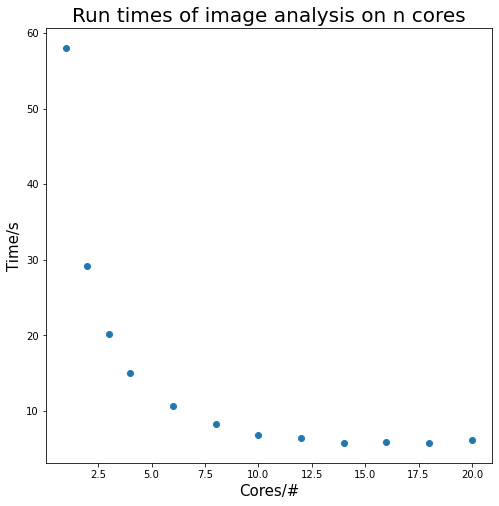

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(cores, timings)
ax.set_xlabel("Cores/#", fontsize=15)
ax.set_ylabel("Time/s", fontsize=15)
ax.set_title("Run times of image analysis on n cores", fontsize=20)

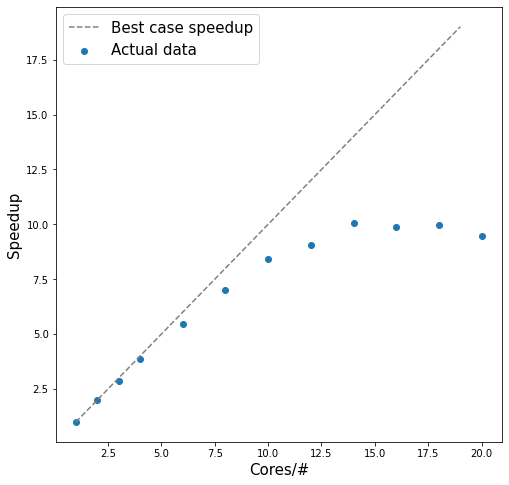

In [25]:
speedup = timings[0] / timings
fig, ax = plt.subplots(1, 1,figsize=(8,8))
ax.scatter(cores, speedup, label="Actual data")
ax.set_xlabel("Cores/#", fontsize=15)
ax.set_ylabel("Speedup", fontsize=15)
ymx = np.arange(1, 20)
ax.plot(ymx, ymx, "--", color="grey", label="Best case speedup")
ax.legend(fontsize=15)

The above exercises were for just 50 of the 4603 we downladed data about. In reality there are billions more galaxies in existence, and SDSS has observed well over 50 million.
## Exercise
1. Using the timing information you calculated above, what is the most efficent amount of cores to use?
2. Using your answer from Q1, how long would it take to run the analysis code on all 4603 galaxies in the downloaded data. How long would it take to analyse 50 million galaxies?

Possible solutions:
1. Depends on the graph produced in previous exercise, but should be around 16 cores.
2. If it takes 5.78s for 14 cores to analyse 50 galaxies, then it would take ~9 mins for 4603, and ~67 days for 50 million.

# Bonus harder material

Amdahl's law gives the theoretical speed up we can expect from a program that is executed in parallel: 
$S=\frac{1}{(1-p)+\tfrac{p}{n}}$. Where $S$ is the speedup, $p$ is the parallel portion of the program, and $n$ is the number of cores used. We can use this equation, along with timing how long the code takes to execute on different amount of cores to get the maximum possible speedup.
An example of this is, if the parallel portion of the code is 75% (0.75), and the number of cores it runs on is 5, then the maximum possible speed up is: $S=\frac{1}{(1-0.75) + \frac{0.75}{5}}=2.5$.
In the net set of exercises we will explore both these equations, and how we can use them to gaugue the performance of running code in parallel.

## Exercise

1. Define a python function that calculates Amdahls law. It should take the number of cores as its first argument, and the parallel porion as its second. It should return one value, the speed up that Amdahl's law predicts.
2. Use Scipy's optimize.curve_fit [function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html#scipy.optimize.curve_fit) and the Amdahl function you made in Q1 to fit Amdahl's law to your timing data to get the parallel portion of the code. Plot this alongside the figure from question 4 in the last exercise.
3. What value do you get for the parallel portion of the code?
4. Calculate the maximum speed up Amdahls law predicts for this code. Hint examine Amdahl's law as N tends to $\infty$.
5. Plot this maxmium speed up on the graph for Q2.

For plots make sure to add all the proper labels and for plots with more than one line add a legend.

In [26]:
#solution to Q1
def amdahl(n, p):
    return 1. / ((1. - p) + (p / n))

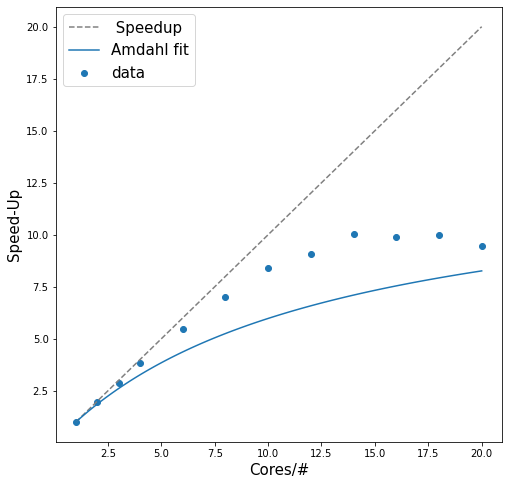

In [27]:
# solution to Q2
from scipy.optimize import curve_fit
popt, _ = curve_fit(amdahl, cores, timings)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# plot ideal speed up, i.e straight line
ax.plot(np.linspace(1, 20, num=100), np.linspace(1, 20, num=100), "--", color="grey", label=" Speedup")
# plot data
ax.scatter(cores, speedup, label="data")
# plot Amdahl fit
ax.plot(np.linspace(1, 20, num=100), amdahl(np.linspace(1, 20, num=100), popt), label="Amdahl fit")

ax.set_xlabel("Cores/#", fontsize=15)
ax.set_ylabel("Speed-Up", fontsize=15)
ax.legend(fontsize=15)

In [28]:
# Solution to Q3
print(f"Parallel portion = {popt[0]:.2f}")

Parallel portion = 0.93


Solution to Q4

As n $\rightarrow$ $\infty$ Amdahls law tends to $S(\infty)=\frac{1}{1-p}$

Therefore, for this run $S(\infty)=\frac{1}{1-.93}\approx 14.3$

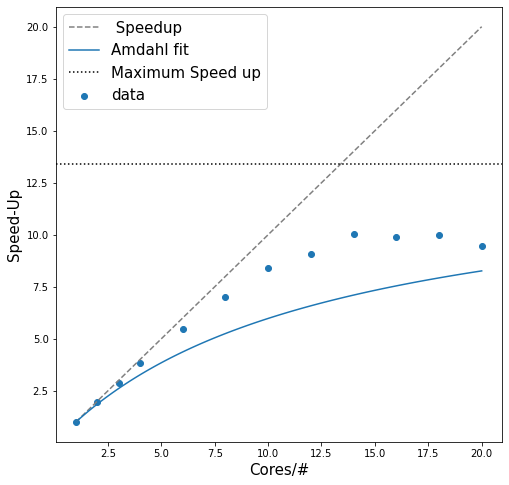

In [29]:
# Solution to Q4
from scipy.optimize import curve_fit
popt, _ = curve_fit(amdahl, cores, timings)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
# plot ideal speed up, i.e straight line
ax.plot(np.linspace(1, 20, num=100), np.linspace(1, 20, num=100), "--", color="grey", label=" Speedup")
# plot data
ax.scatter(cores, speedup, label="data")
# plot Amdahl fit
ax.plot(np.linspace(1, 20, num=100), amdahl(np.linspace(1, 20, num=100), popt), label="Amdahl fit")
# plot maxmimum speedup
ax.axhline(1./(1.-popt[0]), linestyle=":", label="Maximum Speed up", color="black")

ax.set_xlabel("Cores/#", fontsize=15)
ax.set_ylabel("Speed-Up", fontsize=15)
ax.legend(fontsize=15)